In [2]:
# Install Library
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninst

In [3]:
# Import Library
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import pandas_ta as ta

### Data Extraction

In [4]:
#load dataset
start_date = (datetime.now() - relativedelta(years=3)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

df = yf.download("CAT", start=start_date, end=end_date)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df_ori = df.copy()
df.head()

/tmp/ipython-input-1297265356.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("CAT", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-12-22,225.692001,228.789409,221.416452,228.171821,3129900
2022-12-23,227.905807,228.542388,224.703900,225.131452,1959900
2022-12-27,231.012680,232.827417,227.763264,228.684884,3381500
2022-12-28,227.440247,231.658791,226.395106,231.012701,2270000
2022-12-29,228.219345,229.559021,226.385616,229.178978,1652500


### Backtesting Performance

In [5]:
#Define the functions for the strategy
def get_signal_macd(close, fast=12, slow=26, signal=9):
    """
    Pass in a time series of closing price and an optional length for
    the short period exponential moving average (EMA), the long period EMA,
    and the signal period, returns the buying and selling dates.
    MACD trading strategy:
    - Entry: MACD crosses above the signal line (buy on the nex day's open).
    - Exit: MACD crosses below the signal line (sell on the nex day's open).
    """
    buy_date = []
    sell_date = []
    open_pos = False

    # Make sure that it has enough data
    if (len(close) > slow+4):
        # Calculate the MACD
        macd = ta.macd(close, fast=fast, slow=slow, signal=signal)
        macd.dropna(inplace=True)

        # Get the buying and selling dates
        for i in range(1,len(macd)-1):
            # Buy tomorrow if the signal started to move below the MACD
            if (macd.iloc[i,2]   < macd.iloc[i,0]) and \
              (macd.iloc[i-1,2] > macd.iloc[i-1,0]):
                buy_date.append(macd.index[i+1])
                open_pos = True
            # Sell tomorrow if the signal started to move above the MACD
            elif (macd.iloc[i,2]   > macd.iloc[i,0]) and \
                (macd.iloc[i-1,2] < macd.iloc[i-1,0]):
                if open_pos == True:
                    sell_date.append(macd.index[i+1])
                    open_pos = False
        # Warning: remove last buy date if there is no sell date
        if open_pos == True:
            buy_date.pop()
    return buy_date, sell_date

df = df_ori.copy()
buy_date, sell_date = get_signal_macd(df['Close'])

df.ta.bbands(length=20, append=True)
df.dropna(inplace=True)
df.tail(5)

Price,Close,High,Low,Open,Volume,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0
Date,,,,,,,,,,
2025-12-15,589.760010,604.150024,587.890015,602.530029,3968600,531.996046,579.405493,626.814940,16.364859,0.609203
2025-12-16,588.929993,598.659973,586.280029,590.700012,2319400,535.479473,581.249493,627.019514,15.748838,0.583903
2025-12-17,561.890015,591.000000,557.460022,587.590027,3753300,538.150940,581.999994,625.849048,15.068404,0.270691
2025-12-18,565.830017,574.659973,561.909973,568.500000,2193000,540.205226,582.635995,625.066765,14.565104,0.301960
2025-12-19,576.219971,581.729980,570.330017,572.690002,5355100,545.166910,584.140494,623.114077,13.343908,0.398386


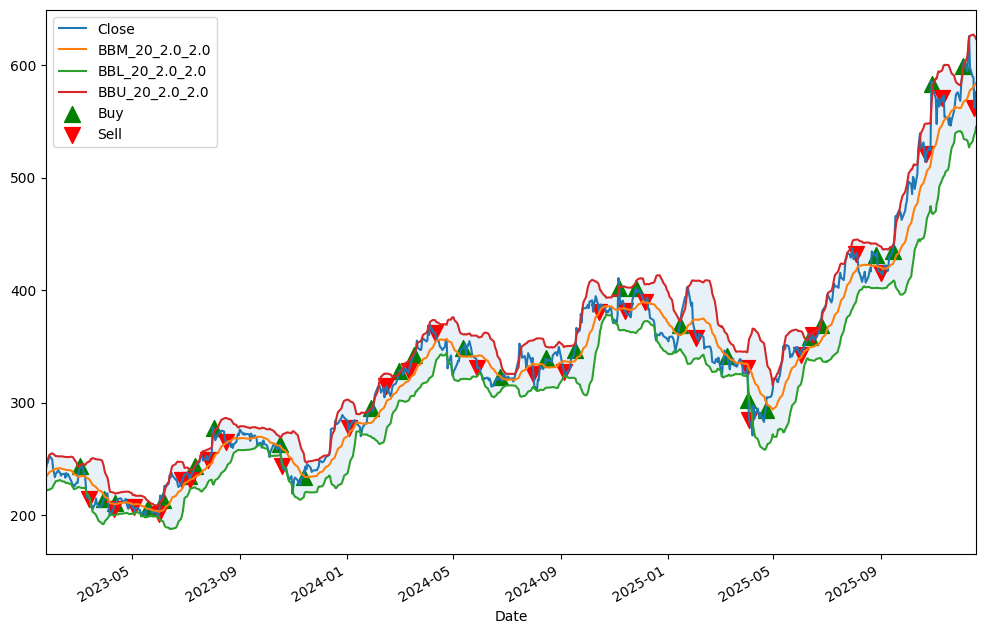

In [6]:
#Visualize MACD Strategy
ax = df[['Close', 'BBM_20_2.0_2.0', 'BBL_20_2.0_2.0', 'BBU_20_2.0_2.0']].plot(figsize=(12,8))
ax.fill_between(df.index, df['BBU_20_2.0_2.0'], df['BBL_20_2.0_2.0'], alpha=0.1);
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

In [8]:
#Calculate the profit
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'],
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2025-10-23,NaN,518.330017
2025-10-30,577.890015,NaN
2025-11-10,NaN,570.000000
2025-12-04,590.179993,NaN
2025-12-17,NaN,587.590027


In [9]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 41.38%
Mean profit: 1.16%
Number of transactions: 29


In [10]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 18 days 04:57:55.862068965
